<i><b>Public AI</b></i>
<br>

# 심층 신경망 분류기 만들기


### _Objective_
1. 텐서플로우를 활용해 심층 신경망 분류기를 만들어봅니다. 
2. 하이퍼파라미터를 결정하여 모델을 학습시켜봅니다. 

In [7]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

### 예제 데이터 ) 암 환자 데이터 셋

나이와 종양크기를 바탕으로 암 환자의 종양이 양성인지 음성인지를 분류하는 데이터셋입니다.

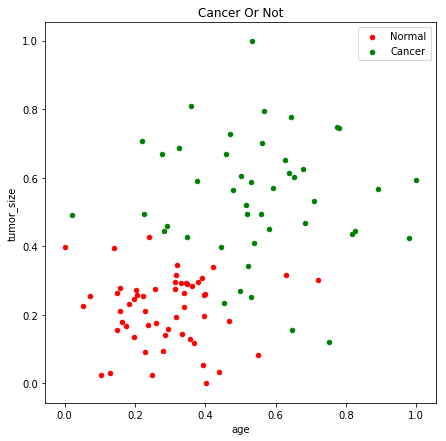

In [8]:
fpath = get_file("cancer_dataset.csv",
                 "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv")
cancer_df = pd.read_csv(fpath)
X = cancer_df[['age','tumor_size']]
y = cancer_df["label"]

X = (X - X.min()) / (X.max() - X.min())

### 데이터 시각화
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='red')
# 1: 암환자
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

## 1. Network Model 생성하기



앞서 심층 신경망 모델의 개념을 배우며 텐서플로우를 이용해 간략하게 1번째 층의 유닛이 10개인 신경망 모델을 만들어봤습니다. 이번에는 1번째 층의 유닛이 200개인 신경망을 만들어봅시다. 

In [9]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

In [10]:
inputs = Input(2,name='x')

dense1 = Dense(200, activation='relu', name='dense_1',)
dense1_output = dense1(inputs)

dense2 = Dense(1, activation='sigmoid', name='dense_2')
dense2_output = dense2(dense1_output)

model = Model(inputs, dense2_output, name='model')

W0206 14:36:53.367995 4556236224 deprecation.py:506] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 2. 학습을 위해 Model 학습과정 설정하기

keras에서는 `compile()`함수를 사용해 학습하기 전에 학습에 대한 설정을 수행합니다. (1) 최적화 함수, (2) 손실 함수, (3) 평가 지표 등을 결정하여 모델을 준비하는 방법을 알아보고, (4) 준비된 최적화 함수, 손실 함수, 평가지표 등으로 구성된 모델을 컴파일하는 방법을 알아봅시다. 

### (1) 최적화 함수 결정하기

신경망 학습의 목적은 Loss Function의 결과값을 최소화하는 매개변수를 찾는 것입니다. 즉, 매개변수의 최적값을 찾는 것이 신경망 학습의 주된 문제이며 이러한 문제를 푸는 것을 **최적화**라고 합니다.최적화를 도와주는 함수로는 `SGD`, `momentum`, `NAG`, `Adagrad`, `RMSprop`, `Adam`등이 있습니다. 

keras에서는 아래와 같이 최적화 함수를 적용할 수 있습니다.

In [11]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop, Adam

In [12]:
optim = SGD(learning_rate=1e-2)
optim = RMSprop(learning_rate=1e-2, rho=0.9)
optim = Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999)

최적화 함수와 같이 직접 설정해주어야 하는 매개변수를 **하이퍼파라미터**라고 합니다. 하이퍼파라미터는 편향(bias)나 가중치(weight) 같은 신경망의 매개변수와는 성질이 다른 매개변수입니다. 신경망의 가중치는 훈련데이터와 학습 알고리즘에 의해서 자동으로 획득되는 매개변수인 반면, 최적화 함수와 같은 하이퍼파라미터는 사람이 직접 설정해야 하는 매개변수입니다. 일반적으로 이 하이퍼파라미터들은 여러 후보 값 중에서 시험을 통해 가장 잘 학습하는 값을 찾는 과정을 거쳐야 하는데, 이 과정을 하이퍼파라미터 최적화라고 합니다.

### (2) 손실함수 결정하기

손실함수에는 MSE외에 mean_absolute_error, categorical_crossentropy, binary_crossentropy등의 종류가 있습니다. MAE(mean_absolute_errer)는 MSE에서 제곱 대신 절댓값을 취한 함수로 특이점에 크게 영향을 받지 않는다는 장점이 있습니다. 보통 classification문제를 해결할 때 crossentropy 함수들을 사용합니다. <br>

아래의 표는 모델에 맞는 마지막 층의 활성화 함수와 손실 함수 선택을 정리한 표입니다.

| 문제 유형 | 마지막 층의 활성화 함수 | 손실 함수 |
| --- | --- | --- |
| 이진 분류 | 시그모이드 | binary_crossentropy |
| 단일 label 다중 분류 | 소프트맥스 | categorical_crossentropy |
| 다중 label 다중 분류 | 시그모이드 | binary_crossentropy |
| 임의 값에 대한 회귀 | 없음 | mse |
| 0과 1 사이 값에 대한 회귀 | 시그모이드 | mse 또는 binary_crossentropy|

In [13]:
from tensorflow.keras.losses import BinaryCrossentropy

loss_func = BinaryCrossentropy()

### (3)  평가 지표 결정하기

keras에서는 `tensorflow.keras.metrics`를 통해 평가 지표를 설정할 수 있습니다. 주요 평가지표로는 정확도를 나타내는 accuracy, binary_accuracy, categorical_accuracy, 상위 k개 예측값의 정확도를 나타내는 top_k_categorical_accuracy등이 있습니다.

In [14]:
from tensorflow.keras.metrics import BinaryAccuracy

In [15]:
metric_func = BinaryAccuracy()

### (4) 모델 컴파일하기

keras의 `compile()` 과정에서 우리는 하이퍼파라미터인 최적화 함수, 손실함수, 평가 지표를 설정합니다. 이 과정에서 케라스의 기본 백엔드인 tensorflow에서는 최적화 함수, 손실함수, 평가 지표를 연결하여 계산 그래프 구성을 마무리하는 작업이 수행됩니다.

In [16]:
model.compile(optimizer=optim,
              loss=loss_func,
              metrics=[metric_func])

W0206 14:37:45.733436 4556236224 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 3. Model 학습시키기

keras에서는 `fit()`함수를 사용해 훈련셋을 이용하여 구성한 모델로 학습시킵니다.

`fit()` 함수의 주요 인자로는 epoch와 batch_size가 있습니다. 전체 훈련 데이터에 수행되는 각 반복을 **에포크(Epoch)**라고 합니다. 각 epoch마다 네트워크가 배치에서 손실에 대한 가중치의 그래디언트를 계산하고 그에 맞추어 가중치를 업데이트 합니다. batch_size는 기본 32로 설정되어 있습니다. 한 번에 32개의 데이터씩 처리한다는 의미입니다. 

In [17]:
history = model.fit(X, y, epochs=1000, verbose=2)

Epoch 1/1000
100/100 - 0s - loss: 0.6732 - binary_accuracy: 0.6800
Epoch 2/1000
100/100 - 0s - loss: 0.6110 - binary_accuracy: 0.8800
Epoch 3/1000
100/100 - 0s - loss: 0.5410 - binary_accuracy: 0.9000
Epoch 4/1000
100/100 - 0s - loss: 0.4633 - binary_accuracy: 0.9400
Epoch 5/1000
100/100 - 0s - loss: 0.3847 - binary_accuracy: 0.9300
Epoch 6/1000
100/100 - 0s - loss: 0.3242 - binary_accuracy: 0.8700
Epoch 7/1000
100/100 - 0s - loss: 0.2794 - binary_accuracy: 0.9200
Epoch 8/1000
100/100 - 0s - loss: 0.2771 - binary_accuracy: 0.9300
Epoch 9/1000
100/100 - 0s - loss: 0.2414 - binary_accuracy: 0.9100
Epoch 10/1000
100/100 - 0s - loss: 0.2245 - binary_accuracy: 0.8900
Epoch 11/1000
100/100 - 0s - loss: 0.2327 - binary_accuracy: 0.8700
Epoch 12/1000
100/100 - 0s - loss: 0.2116 - binary_accuracy: 0.9000
Epoch 13/1000
100/100 - 0s - loss: 0.2139 - binary_accuracy: 0.9300
Epoch 14/1000
100/100 - 0s - loss: 0.1933 - binary_accuracy: 0.9100
Epoch 15/1000
100/100 - 0s - loss: 0.2203 - binary_accura

Epoch 122/1000
100/100 - 0s - loss: 0.1731 - binary_accuracy: 0.9300
Epoch 123/1000
100/100 - 0s - loss: 0.1643 - binary_accuracy: 0.9300
Epoch 124/1000
100/100 - 0s - loss: 0.1647 - binary_accuracy: 0.9300
Epoch 125/1000
100/100 - 0s - loss: 0.1633 - binary_accuracy: 0.9300
Epoch 126/1000
100/100 - 0s - loss: 0.1616 - binary_accuracy: 0.9300
Epoch 127/1000
100/100 - 0s - loss: 0.1659 - binary_accuracy: 0.9200
Epoch 128/1000
100/100 - 0s - loss: 0.1630 - binary_accuracy: 0.9200
Epoch 129/1000
100/100 - 0s - loss: 0.1659 - binary_accuracy: 0.9200
Epoch 130/1000
100/100 - 0s - loss: 0.1674 - binary_accuracy: 0.9300
Epoch 131/1000
100/100 - 0s - loss: 0.1684 - binary_accuracy: 0.9200
Epoch 132/1000
100/100 - 0s - loss: 0.1708 - binary_accuracy: 0.9300
Epoch 133/1000
100/100 - 0s - loss: 0.1717 - binary_accuracy: 0.9200
Epoch 134/1000
100/100 - 0s - loss: 0.1677 - binary_accuracy: 0.9300
Epoch 135/1000
100/100 - 0s - loss: 0.1645 - binary_accuracy: 0.9300
Epoch 136/1000
100/100 - 0s - loss

Epoch 241/1000
100/100 - 0s - loss: 0.1449 - binary_accuracy: 0.9400
Epoch 242/1000
100/100 - 0s - loss: 0.1336 - binary_accuracy: 0.9400
Epoch 243/1000
100/100 - 0s - loss: 0.1298 - binary_accuracy: 0.9300
Epoch 244/1000
100/100 - 0s - loss: 0.1632 - binary_accuracy: 0.9400
Epoch 245/1000
100/100 - 0s - loss: 0.1283 - binary_accuracy: 0.9500
Epoch 246/1000
100/100 - 0s - loss: 0.1622 - binary_accuracy: 0.9000
Epoch 247/1000
100/100 - 0s - loss: 0.1725 - binary_accuracy: 0.9000
Epoch 248/1000
100/100 - 0s - loss: 0.1370 - binary_accuracy: 0.9500
Epoch 249/1000
100/100 - 0s - loss: 0.1496 - binary_accuracy: 0.9500
Epoch 250/1000
100/100 - 0s - loss: 0.1461 - binary_accuracy: 0.9400
Epoch 251/1000
100/100 - 0s - loss: 0.1292 - binary_accuracy: 0.9400
Epoch 252/1000
100/100 - 0s - loss: 0.1775 - binary_accuracy: 0.8900
Epoch 253/1000
100/100 - 0s - loss: 0.1514 - binary_accuracy: 0.9400
Epoch 254/1000
100/100 - 0s - loss: 0.1583 - binary_accuracy: 0.9500
Epoch 255/1000
100/100 - 0s - loss

Epoch 360/1000
100/100 - 0s - loss: 0.1150 - binary_accuracy: 0.9400
Epoch 361/1000
100/100 - 0s - loss: 0.1189 - binary_accuracy: 0.9400
Epoch 362/1000
100/100 - 0s - loss: 0.1220 - binary_accuracy: 0.9400
Epoch 363/1000
100/100 - 0s - loss: 0.1182 - binary_accuracy: 0.9400
Epoch 364/1000
100/100 - 0s - loss: 0.1139 - binary_accuracy: 0.9400
Epoch 365/1000
100/100 - 0s - loss: 0.1147 - binary_accuracy: 0.9400
Epoch 366/1000
100/100 - 0s - loss: 0.1156 - binary_accuracy: 0.9400
Epoch 367/1000
100/100 - 0s - loss: 0.1135 - binary_accuracy: 0.9400
Epoch 368/1000
100/100 - 0s - loss: 0.1125 - binary_accuracy: 0.9400
Epoch 369/1000
100/100 - 0s - loss: 0.1113 - binary_accuracy: 0.9400
Epoch 370/1000
100/100 - 0s - loss: 0.1129 - binary_accuracy: 0.9600
Epoch 371/1000
100/100 - 0s - loss: 0.1345 - binary_accuracy: 0.9400
Epoch 372/1000
100/100 - 0s - loss: 0.1199 - binary_accuracy: 0.9600
Epoch 373/1000
100/100 - 0s - loss: 0.1192 - binary_accuracy: 0.9300
Epoch 374/1000
100/100 - 0s - loss

Epoch 479/1000
100/100 - 0s - loss: 0.1053 - binary_accuracy: 0.9600
Epoch 480/1000
100/100 - 0s - loss: 0.1047 - binary_accuracy: 0.9600
Epoch 481/1000
100/100 - 0s - loss: 0.1066 - binary_accuracy: 0.9500
Epoch 482/1000
100/100 - 0s - loss: 0.1038 - binary_accuracy: 0.9600
Epoch 483/1000
100/100 - 0s - loss: 0.1065 - binary_accuracy: 0.9600
Epoch 484/1000
100/100 - 0s - loss: 0.1055 - binary_accuracy: 0.9600
Epoch 485/1000
100/100 - 0s - loss: 0.1005 - binary_accuracy: 0.9600
Epoch 486/1000
100/100 - 0s - loss: 0.0981 - binary_accuracy: 0.9500
Epoch 487/1000
100/100 - 0s - loss: 0.0987 - binary_accuracy: 0.9500
Epoch 488/1000
100/100 - 0s - loss: 0.0993 - binary_accuracy: 0.9500
Epoch 489/1000
100/100 - 0s - loss: 0.0993 - binary_accuracy: 0.9500
Epoch 490/1000
100/100 - 0s - loss: 0.0982 - binary_accuracy: 0.9500
Epoch 491/1000
100/100 - 0s - loss: 0.0979 - binary_accuracy: 0.9500
Epoch 492/1000
100/100 - 0s - loss: 0.0970 - binary_accuracy: 0.9500
Epoch 493/1000
100/100 - 0s - loss

Epoch 598/1000
100/100 - 0s - loss: 0.1031 - binary_accuracy: 0.9500
Epoch 599/1000
100/100 - 0s - loss: 0.1038 - binary_accuracy: 0.9500
Epoch 600/1000
100/100 - 0s - loss: 0.0994 - binary_accuracy: 0.9400
Epoch 601/1000
100/100 - 0s - loss: 0.0967 - binary_accuracy: 0.9500
Epoch 602/1000
100/100 - 0s - loss: 0.0948 - binary_accuracy: 0.9500
Epoch 603/1000
100/100 - 0s - loss: 0.0963 - binary_accuracy: 0.9500
Epoch 604/1000
100/100 - 0s - loss: 0.0942 - binary_accuracy: 0.9500
Epoch 605/1000
100/100 - 0s - loss: 0.0915 - binary_accuracy: 0.9500
Epoch 606/1000
100/100 - 0s - loss: 0.0926 - binary_accuracy: 0.9500
Epoch 607/1000
100/100 - 0s - loss: 0.0926 - binary_accuracy: 0.9600
Epoch 608/1000
100/100 - 0s - loss: 0.0920 - binary_accuracy: 0.9700
Epoch 609/1000
100/100 - 0s - loss: 0.0902 - binary_accuracy: 0.9700
Epoch 610/1000
100/100 - 0s - loss: 0.0895 - binary_accuracy: 0.9700
Epoch 611/1000
100/100 - 0s - loss: 0.0900 - binary_accuracy: 0.9600
Epoch 612/1000
100/100 - 0s - loss

Epoch 717/1000
100/100 - 0s - loss: 0.0957 - binary_accuracy: 0.9600
Epoch 718/1000
100/100 - 0s - loss: 0.0893 - binary_accuracy: 0.9700
Epoch 719/1000
100/100 - 0s - loss: 0.0924 - binary_accuracy: 0.9600
Epoch 720/1000
100/100 - 0s - loss: 0.1010 - binary_accuracy: 0.9500
Epoch 721/1000
100/100 - 0s - loss: 0.0933 - binary_accuracy: 0.9600
Epoch 722/1000
100/100 - 0s - loss: 0.0831 - binary_accuracy: 0.9500
Epoch 723/1000
100/100 - 0s - loss: 0.0847 - binary_accuracy: 0.9600
Epoch 724/1000
100/100 - 0s - loss: 0.0855 - binary_accuracy: 0.9600
Epoch 725/1000
100/100 - 0s - loss: 0.0852 - binary_accuracy: 0.9700
Epoch 726/1000
100/100 - 0s - loss: 0.0841 - binary_accuracy: 0.9600
Epoch 727/1000
100/100 - 0s - loss: 0.0799 - binary_accuracy: 0.9700
Epoch 728/1000
100/100 - 0s - loss: 0.0819 - binary_accuracy: 0.9800
Epoch 729/1000
100/100 - 0s - loss: 0.0901 - binary_accuracy: 0.9700
Epoch 730/1000
100/100 - 0s - loss: 0.0856 - binary_accuracy: 0.9700
Epoch 731/1000
100/100 - 0s - loss

Epoch 836/1000
100/100 - 0s - loss: 0.0669 - binary_accuracy: 0.9800
Epoch 837/1000
100/100 - 0s - loss: 0.0662 - binary_accuracy: 0.9800
Epoch 838/1000
100/100 - 0s - loss: 0.0669 - binary_accuracy: 0.9900
Epoch 839/1000
100/100 - 0s - loss: 0.0670 - binary_accuracy: 0.9900
Epoch 840/1000
100/100 - 0s - loss: 0.0652 - binary_accuracy: 0.9900
Epoch 841/1000
100/100 - 0s - loss: 0.0676 - binary_accuracy: 0.9700
Epoch 842/1000
100/100 - 0s - loss: 0.0679 - binary_accuracy: 0.9800
Epoch 843/1000
100/100 - 0s - loss: 0.0667 - binary_accuracy: 0.9900
Epoch 844/1000
100/100 - 0s - loss: 0.0668 - binary_accuracy: 0.9900
Epoch 845/1000
100/100 - 0s - loss: 0.0714 - binary_accuracy: 0.9700
Epoch 846/1000
100/100 - 0s - loss: 0.0708 - binary_accuracy: 0.9800
Epoch 847/1000
100/100 - 0s - loss: 0.0681 - binary_accuracy: 0.9800
Epoch 848/1000
100/100 - 0s - loss: 0.0660 - binary_accuracy: 0.9800
Epoch 849/1000
100/100 - 0s - loss: 0.0655 - binary_accuracy: 0.9800
Epoch 850/1000
100/100 - 0s - loss

Epoch 955/1000
100/100 - 0s - loss: 0.0606 - binary_accuracy: 0.9800
Epoch 956/1000
100/100 - 0s - loss: 0.0656 - binary_accuracy: 0.9600
Epoch 957/1000
100/100 - 0s - loss: 0.0751 - binary_accuracy: 0.9600
Epoch 958/1000
100/100 - 0s - loss: 0.0678 - binary_accuracy: 0.9600
Epoch 959/1000
100/100 - 0s - loss: 0.0615 - binary_accuracy: 0.9800
Epoch 960/1000
100/100 - 0s - loss: 0.0590 - binary_accuracy: 0.9900
Epoch 961/1000
100/100 - 0s - loss: 0.0651 - binary_accuracy: 0.9700
Epoch 962/1000
100/100 - 0s - loss: 0.0625 - binary_accuracy: 0.9800
Epoch 963/1000
100/100 - 0s - loss: 0.0689 - binary_accuracy: 0.9800
Epoch 964/1000
100/100 - 0s - loss: 0.0787 - binary_accuracy: 0.9700
Epoch 965/1000
100/100 - 0s - loss: 0.0721 - binary_accuracy: 0.9800
Epoch 966/1000
100/100 - 0s - loss: 0.0610 - binary_accuracy: 0.9900
Epoch 967/1000
100/100 - 0s - loss: 0.0588 - binary_accuracy: 0.9900
Epoch 968/1000
100/100 - 0s - loss: 0.0576 - binary_accuracy: 0.9900
Epoch 969/1000
100/100 - 0s - loss

한편, keras에서는 `history`함수를 사용해 모델 학습 시 훈련셋, 검증셋의 손실 및 정확도를 측정합니다. 반복횟수에 따른 손실 및 정확도 추이를 보면서 학습 상황을 판단합니다.

아래 그래프를 보면, `epoch = 1000`으로 설정함에 따라, 1000번 반복하여 모델을 훈련하는 과정에서 손실이 줄어드는 것을 확인할 수 있습니다. 

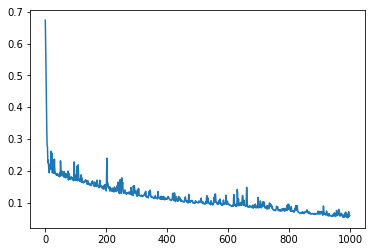

In [18]:
plt.plot(history.history['loss'])
plt.show()

아래 그래프를 보면 1000번을 반복하여 모델을 훈련하는 과정에서 정확도가 올라가는 것을 확인할 수 있습니다.  

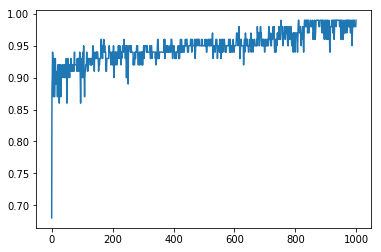

In [19]:
plt.plot(history.history['binary_accuracy'])
plt.show()

## 4. 결과 확인하기

자, 이제 모델을 만들고 학습시켜 보았습니다. `results = model.predict(xs)`를 이용해 만들어진 모델에 데이터를 넣고 결과값을 예측해봅시다. 그래프를 보면, 단순히 직선으로 암 환자와 정상을 구분하지 않고, 다수의 곡선으로 경계가 나뉘어진 것을 확인할 수 있습니다. 

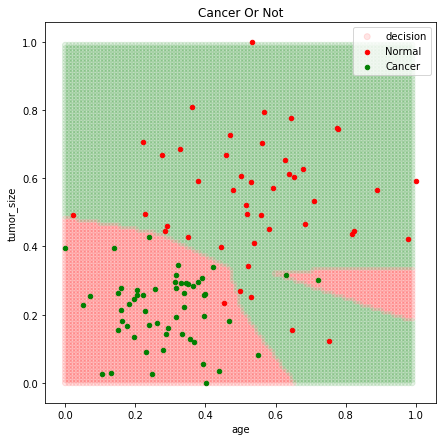

In [21]:
x1s,x2s = np.mgrid[0:1:0.01,0:1:0.01]
xs = np.stack([x1s.ravel(),x2s.ravel()],axis=1)

results = model.predict(xs) # 결과 예측

colors = []
for result in results.ravel():
    if result > 0.5:
        colors.append('g')
    else:
        colors.append('r')
        
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(xs[:,0],xs[:,1],c=colors,alpha=0.1)

# 0: 정상
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='red')
# 1: 암환자
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                                   kind='scatter',color='green')
plt.legend(["decision",'Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/09/16


---